In [ ]:
# Intelligent Systems - Assignment 1

- Author: Tim Hrovat
- Student no.: 63230112
- Date: 11. 1. 2026

## Introduction

This section imports the essential libraries for running my solutions.

In [4]:
import sys
# uncomment the following line if any of the packages are not installed
!{sys.executable} -m pip install pandas numpy matplotlib scikit-learn seaborn IPython

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from IPython.display import display, HTML

## Load Data

In [5]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


def load_jsonl(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data


def load_english_dataset():
    train_data = load_jsonl('data/English dataset/train.jsonl')
    test_data = load_jsonl('data/English dataset/test.jsonl')

    return pd.DataFrame(train_data), pd.DataFrame(test_data)

## Task 1

,Column,Null Values,Empty Strings,Total Issues,Issue Rate (%)
0,premise,0,2820,2820,39.22%
1,hypothesis,0,0,0,0.00%


,Duplicate Type,Count,Percentage
0,Exact duplicate rows,0,0.00%
1,Duplicate text pairs (premise+hypothesis),2882,40.08%
2,Duplicate premises (non-empty only),656,15.01%


,Metric,Value
0,Total Examples,7191
1,Unique Documents,423
2,Unique Keys,17
3,Avg Examples/Doc,17.00
4,Contradiction Count,841
5,Contradiction Rate,11.70%


,Class,Label,Count,Percentage
0,Non-Contradiction,0,6350,88.30%
1,Contradiction,1,841,11.70%


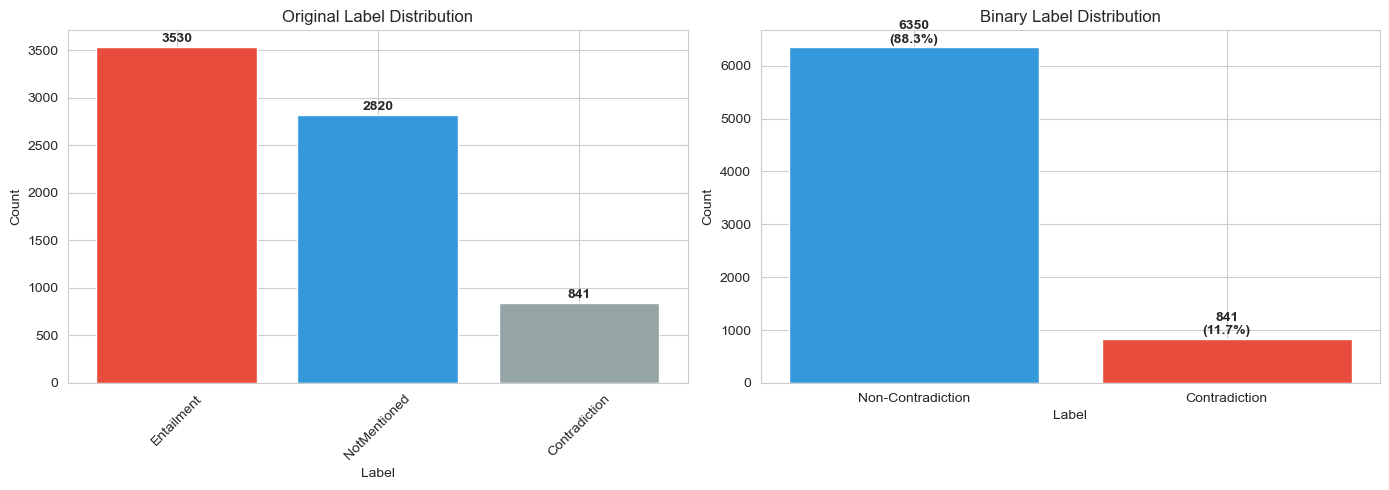

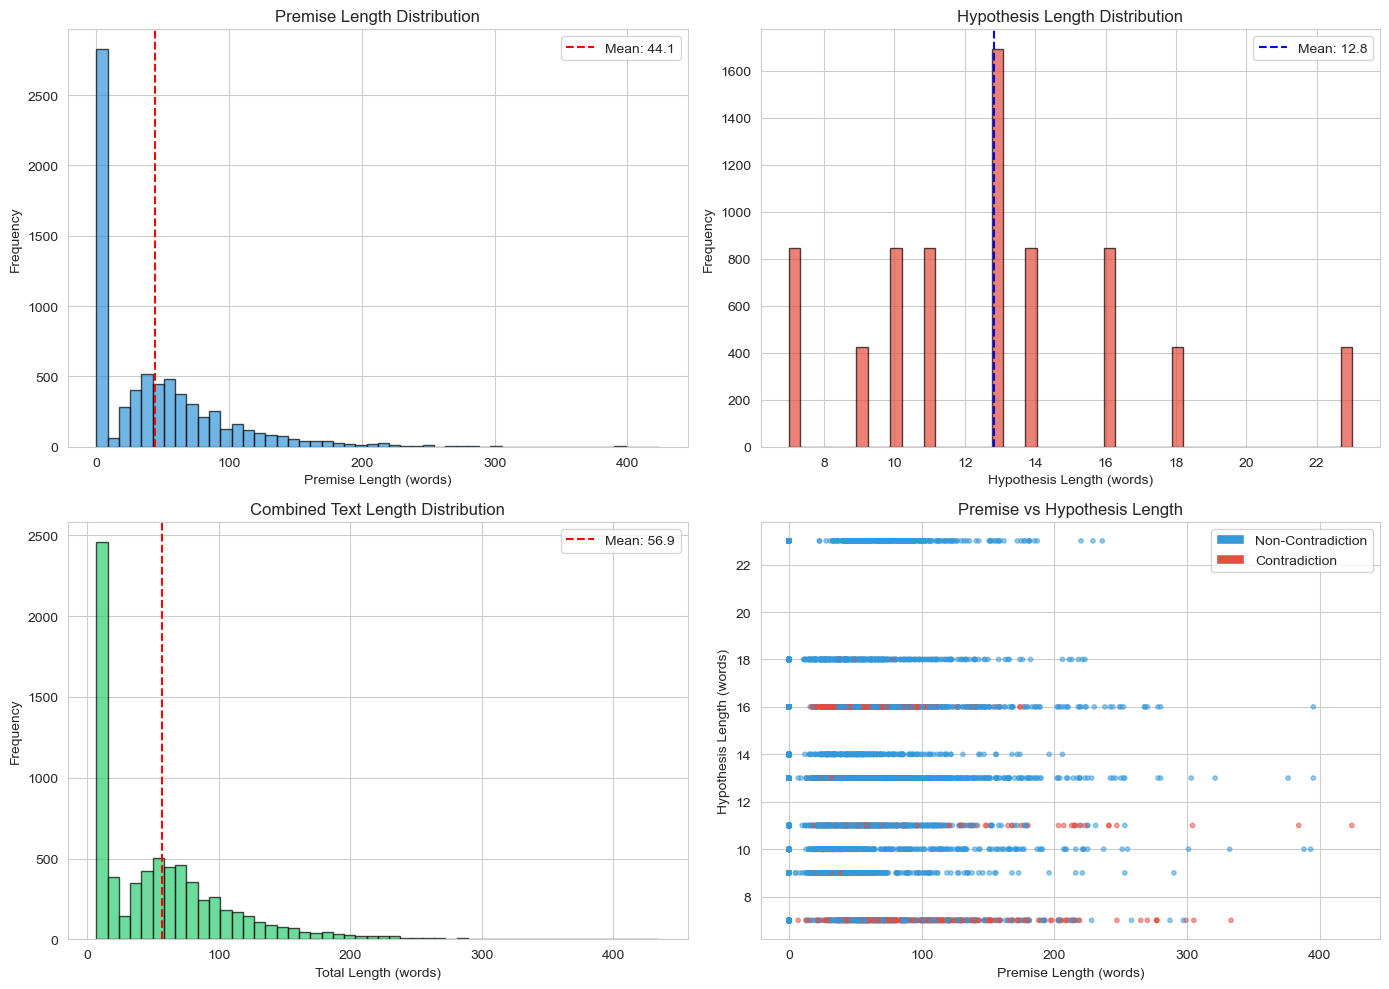

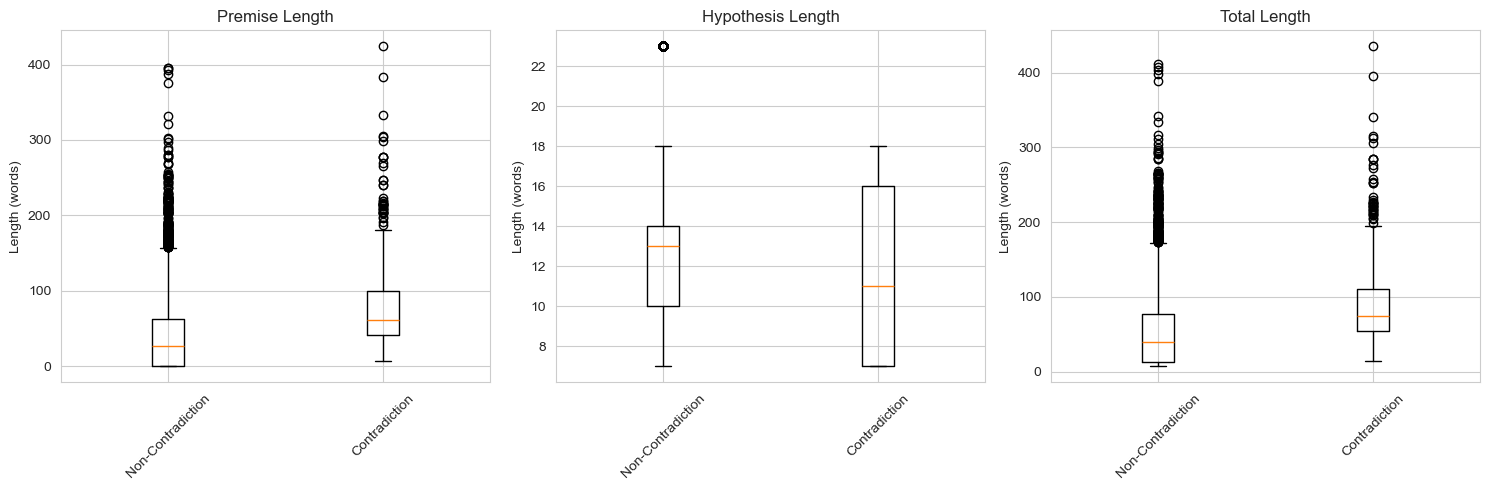

,Document ID,Key,Label,Premise,Hypothesis,Binary Label
0,359,nda-2,Contradiction,“Confidential Information” means technical and...,Confidential Information shall only include te...,Contradiction
1,602,nda-2,Contradiction,"The Parties acknowledge that, in the course of...",Confidential Information shall only include te...,Contradiction
2,101,nda-20,Contradiction,"All Confidential Information, whether original...",Receiving Party may retain some Confidential I...,Contradiction
3,396,nda-7,Contradiction,2. With respect to all Discloser's Proprietary...,Receiving Party may share some Confidential In...,Contradiction
4,134,nda-1,Contradiction,This Agreement shall apply to all Confidential...,All Confidential Information shall be expressl...,Contradiction


,Text Type,Min,Max,Mean,Median,Std Dev
0,Premise,0,424,44.1,34.0,51.9
1,Hypothesis,7,23,12.8,13.0,3.9
2,Total,7,435,56.9,47.0,52.1


In [11]:
def t1_transform_to_binary(df, strategy='contradiction_vs_rest'):
    """Transform multi-class labels to binary classification."""
    df = df.copy()

    if strategy == 'contradiction_vs_rest':
        df['binary_label'] = (df['label'] == 'Contradiction').astype(int)

    return df


def t1_combine_text_pairs(df):
    """Combine premise and hypothesis into text pairs for analysis."""
    df = df.copy()

    df['text_pair'] = df['premise'] + ' [SEP] ' + df['hypothesis']
    df['premise_filled'] = df['premise'].replace('', '[NO PREMISE]')

    return df



def t1_check_missing_values(df):
    """Check for missing values and empty strings in the dataset."""
    text_cols = ['premise', 'hypothesis']
    quality_data = []

    for col in text_cols:
        if col in df.columns:
            null_count = df[col].isnull().sum()
            empty_count = (df[col] == '').sum()
            total_issues = null_count + empty_count
            quality_data.append({
                'Column': col,
                'Null Values': null_count,
                'Empty Strings': empty_count,
                'Total Issues': total_issues,
                'Issue Rate (%)': f'{(total_issues / len(df) * 100):.2f}%'
            })

    return pd.DataFrame(quality_data)


def t1_check_duplicates(df):
    """Check for duplicate entries in the dataset."""
    duplicates = df.duplicated().sum()
    text_pair_dupes = df.duplicated(subset=['premise', 'hypothesis']).sum()
    premise_dupes = df[df['premise'] != ''].duplicated(subset=['premise']).sum()

    dup_data = {
        'Duplicate Type': [
            'Exact duplicate rows',
            'Duplicate text pairs (premise+hypothesis)',
            'Duplicate premises (non-empty only)'
        ],
        'Count': [duplicates, text_pair_dupes, premise_dupes],
        'Percentage': [
            f'{(duplicates/len(df)*100):.2f}%',
            f'{(text_pair_dupes/len(df)*100):.2f}%',
            f'{(premise_dupes/len(df[df["premise"] != ""])*100):.2f}%' if len(df[df['premise'] != '']) > 0 else '0.00%'
        ]
    }

    return pd.DataFrame(dup_data)


def t1_compute_statistics(df):
    """Compute comprehensive dataset statistics."""
    overview_data = {
        'Total Examples': [len(df)],
        'Unique Documents': [df['doc_id'].nunique()],
        'Unique Keys': [df['key'].nunique()],
        'Avg Examples/Doc': [f"{len(df) / df['doc_id'].nunique():.2f}"],
    }

    if 'binary_label' in df.columns:
        overview_data['Contradiction Count'] = [int(df['binary_label'].sum())]
        overview_data['Contradiction Rate'] = [f"{(df['binary_label'].sum()/len(df)*100):.2f}%"]

    if 'premise_len' in df.columns and 'hypothesis_len' in df.columns:
        overview_data['Avg Premise Length'] = [f"{df['premise_len'].mean():.1f}"]
        overview_data['Avg Hypothesis Length'] = [f"{df['hypothesis_len'].mean():.1f}"]
        overview_data['Avg Total Length'] = [f"{df['total_len'].mean():.1f}"]

    overview_df = pd.DataFrame(overview_data).T.reset_index()
    overview_df.columns = ['Metric', 'Value']

    label_df = None
    if 'binary_label' in df.columns:
        binary_counts = df['binary_label'].value_counts()
        binary_pct = (df['binary_label'].value_counts(normalize=True) * 100)

        label_df = pd.DataFrame({
            'Class': ['Non-Contradiction', 'Contradiction'],
            'Label': [0, 1],
            'Count': [binary_counts[0], binary_counts[1]],
            'Percentage': [f"{binary_pct[0]:.2f}%", f"{binary_pct[1]:.2f}%"]
        })

    return overview_df, label_df


def t1_analyze_text_lengths(df):
    """Analyze text lengths in the dataset."""
    df['premise_len'] = df['premise'].apply(lambda x: len(x.split()) if x else 0)
    df['hypothesis_len'] = df['hypothesis'].apply(lambda x: len(x.split()) if x else 0)
    df['total_len'] = df['premise_len'] + df['hypothesis_len']
    return df



def t1_split_data(df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """Split data into train, validation, and test sets. Groups by doc_id to prevent data leakage."""
    unique_docs = df['doc_id'].unique()

    train_docs, temp_docs = train_test_split(
        unique_docs,
        train_size=train_size,
        random_state=random_state
    )

    val_ratio = val_size / (val_size + test_size)
    val_docs, test_docs = train_test_split(
        temp_docs,
        train_size=val_ratio,
        random_state=random_state
    )

    train_df = df[df['doc_id'].isin(train_docs)].reset_index(drop=True)
    val_df = df[df['doc_id'].isin(val_docs)].reset_index(drop=True)
    test_df = df[df['doc_id'].isin(test_docs)].reset_index(drop=True)

    return train_df, val_df, test_df



def t1_create_tfidf_features(train_df, val_df, test_df,
                             max_features=5000, ngram_range=(1, 2)):
    """Create TF-IDF features for text pairs."""
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=2,
        max_df=0.95,
        strip_accents='unicode',
        lowercase=True
    )

    X_train = vectorizer.fit_transform(train_df['text_pair'])
    X_val = vectorizer.transform(val_df['text_pair'])
    X_test = vectorizer.transform(test_df['text_pair'])

    return vectorizer, X_train, X_val, X_test


def t1_create_bow_features(train_df, val_df, test_df,
                           max_features=5000, ngram_range=(1, 1)):
    """Create Bag-of-Words features for text pairs."""
    vectorizer = CountVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=2,
        max_df=0.95,
        strip_accents='unicode',
        lowercase=True
    )

    X_train = vectorizer.fit_transform(train_df['text_pair'])
    X_val = vectorizer.transform(val_df['text_pair'])
    X_test = vectorizer.transform(test_df['text_pair'])

    return vectorizer, X_train, X_val, X_test



def t1_plot_label_distribution(df, title='Label Distribution'):
    """Plot label distribution."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    label_counts = df['label'].value_counts()
    axes[0].bar(label_counts.index, label_counts.values, color=['#e74c3c', '#3498db', '#95a5a6'])
    axes[0].set_xlabel('Label')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Original Label Distribution')
    axes[0].tick_params(axis='x', rotation=45)

    for i, v in enumerate(label_counts.values):
        axes[0].text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')

    if 'binary_label' in df.columns:
        binary_counts = df['binary_label'].value_counts().sort_index()
        labels = ['Non-Contradiction', 'Contradiction']
        colors = ['#3498db', '#e74c3c']

        axes[1].bar(labels, binary_counts.values, color=colors)
        axes[1].set_xlabel('Label')
        axes[1].set_ylabel('Count')
        axes[1].set_title('Binary Label Distribution')

        for i, v in enumerate(binary_counts.values):
            pct = v / len(df) * 100
            axes[1].text(i, v + 20, f'{v}\n({pct:.1f}%)',
                        ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return fig


def t1_plot_text_lengths(df, title='Text Length Distribution'):
    """Plot text length distributions."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    axes[0, 0].hist(df['premise_len'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Premise Length (words)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Premise Length Distribution')
    axes[0, 0].axvline(df['premise_len'].mean(), color='red', linestyle='--',
                       label=f'Mean: {df["premise_len"].mean():.1f}')
    axes[0, 0].legend()

    axes[0, 1].hist(df['hypothesis_len'], bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Hypothesis Length (words)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Hypothesis Length Distribution')
    axes[0, 1].axvline(df['hypothesis_len'].mean(), color='blue', linestyle='--',
                       label=f'Mean: {df["hypothesis_len"].mean():.1f}')
    axes[0, 1].legend()

    axes[1, 0].hist(df['total_len'], bins=50, color='#2ecc71', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Total Length (words)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Combined Text Length Distribution')
    axes[1, 0].axvline(df['total_len'].mean(), color='red', linestyle='--',
                       label=f'Mean: {df["total_len"].mean():.1f}')
    axes[1, 0].legend()

    scatter_colors = df['binary_label'].map({0: '#3498db', 1: '#e74c3c'}) if 'binary_label' in df.columns else '#95a5a6'
    axes[1, 1].scatter(df['premise_len'], df['hypothesis_len'],
                      c=scatter_colors, alpha=0.5, s=10)
    axes[1, 1].set_xlabel('Premise Length (words)')
    axes[1, 1].set_ylabel('Hypothesis Length (words)')
    axes[1, 1].set_title('Premise vs Hypothesis Length')

    if 'binary_label' in df.columns:
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#3498db', label='Non-Contradiction'),
            Patch(facecolor='#e74c3c', label='Contradiction')
        ]
        axes[1, 1].legend(handles=legend_elements)

    plt.tight_layout()
    plt.show()

    return fig


def t1_plot_length_by_label(df, title='Text Length by Label'):
    """Plot text length comparison across labels."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    text_types = [
        ('premise_len', 'Premise Length'),
        ('hypothesis_len', 'Hypothesis Length'),
        ('total_len', 'Total Length')
    ]

    for idx, (col, label) in enumerate(text_types):
        if 'binary_label' in df.columns:
            data = [
                df[df['binary_label'] == 0][col],
                df[df['binary_label'] == 1][col]
            ]
            axes[idx].boxplot(data, tick_labels=['Non-Contradiction', 'Contradiction'])
        else:
            labels_unique = df['label'].unique()
            data = [df[df['label'] == lbl][col] for lbl in labels_unique]
            axes[idx].boxplot(data, tick_labels=labels_unique)

        axes[idx].set_ylabel('Length (words)')
        axes[idx].set_title(label)
        axes[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return fig


def t1_get_examples(df, n_examples=5, label_filter=None):
    """Get example contradictions from the dataset."""
    if label_filter is not None:
        if 'binary_label' in df.columns:
            sample_df = df[df['binary_label'] == label_filter].sample(
                n=min(n_examples, len(df[df['binary_label'] == label_filter])),
                random_state=42
            )
        else:
            sample_df = df[df['label'] == label_filter].sample(
                n=min(n_examples, len(df[df['label'] == label_filter])),
                random_state=42
            )
    else:
        sample_df = df.sample(n=min(n_examples, len(df)), random_state=42)

    examples_data = []
    for idx, row in sample_df.iterrows():
        example = {
            'Document ID': row['doc_id'],
            'Key': row['key'],
            'Label': row['label'],
            'Premise': row['premise'][:200] + '...' if len(row['premise']) > 200 else row['premise'],
            'Hypothesis': row['hypothesis'][:200] + '...' if len(row['hypothesis']) > 200 else row['hypothesis']
        }
        if 'binary_label' in row:
            example['Binary Label'] = 'Contradiction' if row['binary_label'] == 1 else 'Non-Contradiction'
        examples_data.append(example)

    return pd.DataFrame(examples_data)


def t1_create_text_length_stats(df):
    """Create text length statistics summary."""
    text_stats = []

    for text_type in ['premise_len', 'hypothesis_len', 'total_len']:
        col_name = text_type.replace('_len', '').capitalize()
        stats_row = {
            'Text Type': col_name,
            'Min': int(df[text_type].min()),
            'Max': int(df[text_type].max()),
            'Mean': f"{df[text_type].mean():.1f}",
            'Median': f"{df[text_type].median():.1f}",
            'Std Dev': f"{df[text_type].std():.1f}"
        }
        text_stats.append(stats_row)

    return pd.DataFrame(text_stats)



def t1_run_full_pipeline(dataset_choice='english'):
    """Execute complete Task 1 pipeline."""
    if dataset_choice == 'english':
        train_raw, test_raw = load_english_dataset()
        df = train_raw.copy()
    else:
        raise NotImplementedError("Slovene dataset processing not yet implemented")

    df = t1_transform_to_binary(df)
    df = t1_combine_text_pairs(df)
    df = t1_analyze_text_lengths(df)

    quality_df = t1_check_missing_values(df)
    duplicate_df = t1_check_duplicates(df)
    overview_df, label_df = t1_compute_statistics(df)

    display(HTML("<h3>Data Quality Check</h3>"))
    display(quality_df)

    display(HTML("<h3>Duplicate Analysis</h3>"))
    display(duplicate_df)

    display(HTML("<h2>Dataset Overview</h2>"))
    display(overview_df)

    if label_df is not None:
        display(HTML("<h3>Binary Classification Distribution</h3>"))
        display(label_df)

    train_df, val_df, test_df = t1_split_data(df)

    tfidf_vectorizer, X_train_tfidf, X_val_tfidf, X_test_tfidf = t1_create_tfidf_features(
        train_df, val_df, test_df
    )

    bow_vectorizer, X_train_bow, X_val_bow, X_test_bow = t1_create_bow_features(
        train_df, val_df, test_df
    )

    fig_labels = t1_plot_label_distribution(df)
    fig_lengths = t1_plot_text_lengths(df)
    fig_length_by_label = t1_plot_length_by_label(df)

    examples_df = t1_get_examples(df, n_examples=5, label_filter=1)
    display(HTML("<h3>Example Contradictions</h3>"))
    display(examples_df)

    text_stats_df = t1_create_text_length_stats(df)
    display(HTML("<h3>Text Length Statistics</h3>"))
    display(text_stats_df)

    results = {
        'original_df': df,
        'train_df': train_df,
        'val_df': val_df,
        'test_df': test_df,
        'tfidf_vectorizer': tfidf_vectorizer,
        'X_train_tfidf': X_train_tfidf,
        'X_val_tfidf': X_val_tfidf,
        'X_test_tfidf': X_test_tfidf,
        'bow_vectorizer': bow_vectorizer,
        'X_train_bow': X_train_bow,
        'X_val_bow': X_val_bow,
        'X_test_bow': X_test_bow,
        'y_train': train_df['binary_label'].values,
        'y_val': val_df['binary_label'].values,
        'y_test': test_df['binary_label'].values,
        'quality_df': quality_df,
        'duplicate_df': duplicate_df,
        'overview_df': overview_df,
        'label_df': label_df,
        'text_stats_df': text_stats_df
    }

    return results


t1_run_full_pipeline(dataset_choice='english');